The length of smiles character is 56
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (last conv layer output): torch.Size([1, 64, 10])
Shape before LSTM: torch.Size([1, 10, 64])
Shape after LSTM: torch.Size([1, 10, 64])
Attention output shape: torch.Size([1, 10, 64])
Logits: tensor([[ 2.7742,  0.1190, -2.4334]])
Output shape after FC layer: torch.Size([1, 3])
Probabilities: tensor([[0.9296, 0.0653, 0.0051]])
O=S(=O)(NCCCCCn1c(C2CCNCC2)nc2cc(Cl)c(Cl)cc21)c1ccccc1 probabilities: [0.929577   0.06533381 0.00508917] -> Predicted to be Inactive with a probability of 0.930 or 93.0%
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv l

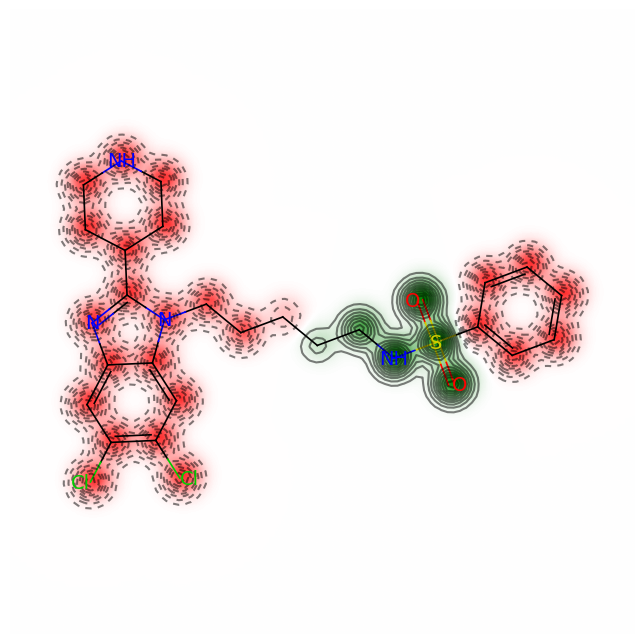

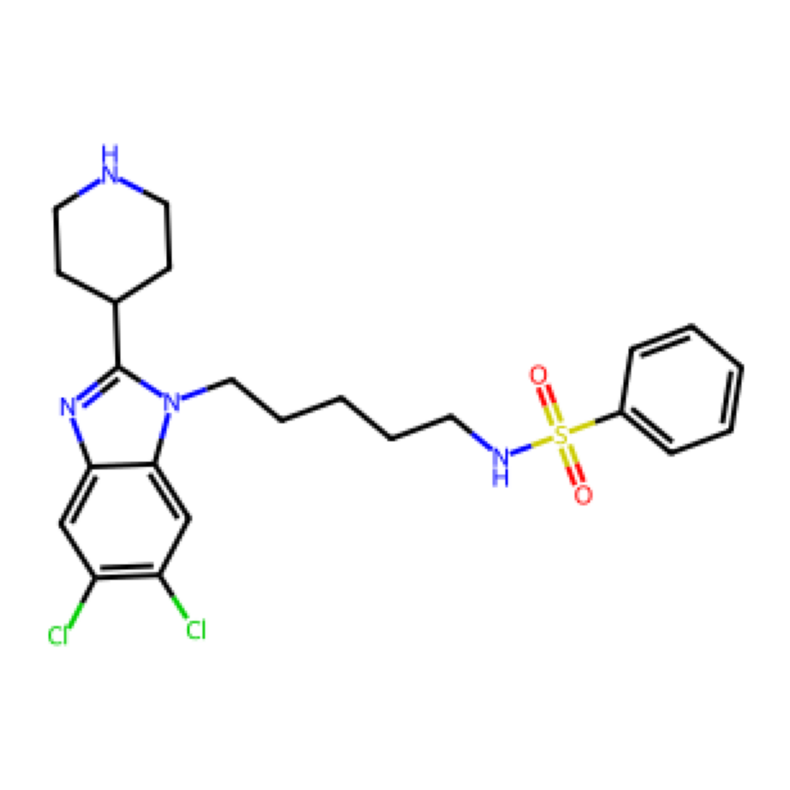

Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (last conv layer output): torch.Size([1, 64, 10])
Shape before LSTM: torch.Size([1, 10, 64])
Shape after LSTM: torch.Size([1, 10, 64])
Attention output shape: torch.Size([1, 10, 64])
Logits: tensor([[ 2.7742,  0.1190, -2.4334]])
Output shape after FC layer: torch.Size([1, 3])
Probabilities: tensor([[0.9296, 0.0653, 0.0051]])
O=S(=O)(NCCCCCn1c(C2CCNCC2)nc2cc(Cl)c(Cl)cc21)c1ccccc1 probabilities: [0.929577   0.06533381 0.00508917] -> Predicted to be Inactive with a probability of 0.930 or 93.0%


In [1]:
import torch
import numpy as np
from torch.autograd import Function
import torch.nn.functional as F
from model import ConvLSTMCAMbiotic
from rdkit.Chem import Descriptors
from data_preprocessing2 import smiles_chars
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import DrawingOptions
import matplotlib.cm as cm
import matplotlib.colors as cc
import os
import matplotlib.colors as mcolors
from rdkit.Chem.Draw import SimilarityMaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import MolToImage
import matplotlib.pyplot as plt
from PIL import Image
import io
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D


# Define a custom colormap: red for negative, white for neutral, green for positive
cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_red", ["red", "white", "green"], N=256)

def smiles_to_tensor(smile, char_to_index, maxlen=350):
    """
    Convert a single SMILES string to a PyTorch tensor.
    
    Args:
    - smile (str): The SMILES string to be converted.
    - char_to_index (dict): A dictionary mapping characters to indices.
    - maxlen (int): Maximum length of the sequence to be padded to.
    
    Returns:
    - torch.Tensor: A PyTorch tensor representing the one-hot encoded SMILES.
    """
    # Convert the SMILES string to a one-hot encoded sequence
    encoded = np.zeros((maxlen, len(char_to_index)), dtype=np.int8)
    for i, char in enumerate(smile):
        if i < maxlen:  # Ensure index doesn't exceed maxlen - 1
            if char in char_to_index:
                encoded[i, char_to_index[char]] = 1
        else:
            break  # Break the loop if index equals or exceeds maxlen
    
    # Convert the numpy array to a PyTorch tensor
    encoded_tensor = torch.from_numpy(encoded).unsqueeze(0)  # Add batch dimension
    encoded_tensor = encoded_tensor.to(dtype=torch.float32)  # Model might expect float
    return encoded_tensor

# Calculate molecular weight using RDKit
def calculate_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.ExactMolWt(mol) if mol else None

# Filter single SMILES string based on specified criteria
def filter_single_smile(smile, maxlen=350, max_mol_wt=650):
    reasons = []
    mol_wt = calculate_molecular_weight(smile)
    
    if len(smile) > maxlen:
        reasons.append('maxlen exceeded')
    if not all(char in smiles_chars for char in smile):
        reasons.append('invalid character')
    if mol_wt is None or mol_wt > max_mol_wt:
        reasons.append('mol wt exceeded')
    
    return ', '.join(reasons) if reasons else 'valid'

# Main prediction function that incorporates SMILES filtering

def predict_smiles(model, smile, maxlen=350, max_mol_wt=650):
    filter_result = filter_single_smile(smile, maxlen, max_mol_wt)
    
    if filter_result != 'valid':
        print(f"This SMILES cannot be predicted because: {filter_result}.")
        return None, None

    char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
    input_tensor = smiles_to_tensor(smile, char_to_index, maxlen).to(model.device)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Get the model's output directly from the forward method
        output = model(input_tensor)
        # The model's forward method returns a tuple, unpack to get probabilities
        probabilities, _, _ = output
        # Move probabilities to CPU and convert to numpy array
        probabilities = probabilities.cpu().numpy()[0]
        predicted_class_index = np.argmax(probabilities)
        predicted_probability = probabilities[predicted_class_index]
    
    # Define class labels in the order they are output by the model
    classes = ["Inactive", "Slightly Active", "Active"]
    prediction_message = f"{smile} probabilities: {probabilities} -> Predicted to be {classes[predicted_class_index]} with a probability of {predicted_probability:.3f} or {predicted_probability*100:.1f}%"
    print(prediction_message)
    return predicted_class_index, probabilities






class ConvLSTMCAMVisualizerGradCAM:
    # Define class labels as a class attribute
    classes = ["Inactive", "Slightly Active", "Active"]
    def __init__(self, model, device='cpu'):
        # Load the model
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.model.to(device)
        self.device = device
        # Define the custom colormap as an attribute of the class
        self.cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_red", ["red", "white", "green"], N=256)

    def prepare_input(self, smiles):
        # Assuming char_to_index is a dictionary mapping SMILES characters to integer indices
        char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
        smiles_tensor = smiles_to_tensor(smiles, char_to_index, maxlen=350).to(self.device)
        return smiles_tensor

    def grad_cam(self, input_tensor, target_class_index):
        self.model.eval()  # Ensure the model is in evaluation mode.
        self.model.zero_grad()  # Reset gradients to zero.

        logits, _, feature_maps = self.model(input_tensor)
        feature_maps.requires_grad_(True)  # Enable gradients for the feature maps

        # Compute softmax probabilities
        probabilities = F.softmax(logits, dim=1)
        # Select the probability of the target class for visualization
        class_prob = probabilities[:, target_class_index]

        # Backpropagate the target class probability
        self.model.zero_grad()
        class_prob.backward(gradient=torch.ones_like(class_prob))

        gradients = feature_maps.grad.data
        pooled_gradients = torch.mean(gradients, dim=[0, 2], keepdim=True)

        for i in range(feature_maps.size(1)):  # Iterate over the channels
            feature_maps.data[:, i, :] *= pooled_gradients[:, i, :]

        heatmap = torch.mean(feature_maps.data, dim=1).squeeze()

        # Apply torch.tanh to get both positive and negative influences
        heatmap = torch.tanh(heatmap)
        heatmap_min = torch.min(heatmap).item()
        heatmap_max = torch.max(heatmap).item()
        
        # Print the range of values in the heatmap
        print(f"Heatmap range before normalization: {heatmap_min}, {heatmap_max}")
        
        # Normalize the heatmap
        heatmap /= torch.max(torch.abs(heatmap))
        heatmap_np = heatmap.cpu().numpy()
        
        # Print the range of values in the heatmap after normalization
        print(f"Heatmap range after normalization: {heatmap_np.min()}, {heatmap_np.max()}")

        return heatmap_np, heatmap_min, heatmap_max



   
    def interpolate_heatmap_to_atoms(self, smiles, heatmap): #Adding self to the method signature allows you to call other methods within this method and access class attributes showinng that it is an instance method
        """Interpolate the heatmap to match the number of atoms in the molecule."""
        # Convert SMILES to RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the number of atoms
        num_atoms = mol.GetNumAtoms()

        # Create an interpolation function
        interpolate = interp1d(np.arange(len(heatmap)), heatmap, fill_value="extrapolate")
        
        # Generate new heatmap values that match the number of atoms
        new_heatmap = interpolate(np.linspace(0, len(heatmap) - 1, num_atoms))
        
        return new_heatmap    
    
    def visualize_plain_molecule(self, smiles):
        """Visualize plain 2D structure of the molecule given a SMILES string."""
        mol = Chem.MolFromSmiles(smiles)
        img = MolToImage(mol, size=(300, 300))
        # Convert PIL Image to a format that can be displayed by matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()




    def visualize_combined_heatmap(self, smiles, predicted_class_index):
        input_tensor = self.prepare_input(smiles)
        
        # Generate heatmap for the predicted class and get min/max values
        heatmap, vmin, vmax = self.grad_cam(input_tensor, predicted_class_index)
        
        # Interpolate heatmap to match the number of atoms in the molecule
        interpolated_heatmap = self.interpolate_heatmap_to_atoms(smiles, heatmap)

        # Define the output image path
        heatmap_filename = f'{self.classes[predicted_class_index]}_heatmap.png'

        # Overlay and visualize heatmap for the predicted class using the custom colormap
        self.overlay_heatmap_on_molecule(smiles, interpolated_heatmap, heatmap_filename, vmin, vmax)


        

    def overlay_heatmap_on_molecule(self, smiles, heatmap, output_image_path, vmin, vmax):

        # Convert SMILES to RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)

        # Normalize the heatm ap values to span from vmin to vmax
        norm = Normalize(vmin=vmin, vmax=vmax)
        # ...
        print(f"Overlaying heatmap: {output_image_path}")
        print(f"Using normalization: vmin={vmin}, vmax={vmax}")


        # Generate and save the similarity map with the custom colormap
        fig, ax = plt.subplots()
        fig.patch.set_facecolor('white')
        SimilarityMaps.GetSimilarityMapFromWeights(mol, [norm(value) for value in heatmap], colorMap=self.cmap, contourLines=20)
        print(f"Overlaying heatmap on molecule with vmin: {vmin}, vmax: {vmax}")
        plt.axis('off')
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close(fig)

        print(f"Saved heatmap to {output_image_path}")















if __name__ == "__main__":
    

    model_checkpoint_path = 'Seed Randomization_SA/models500/checkpoint-epoch=198-val_loss=0.67.ckpt' # replace with model checkpoint path
    #model_checkpoint_path = 'Seed Randomization_SA/models50/checkpoint-epoch=197-val_loss=0.67.ckpt'
    #model_checkpoint_path = 'Seed Randomization_SA/models5/checkpoint-epoch=196-val_loss=0.67.ckpt'
    trained_model = ConvLSTMCAMbiotic.load_from_checkpoint(model_checkpoint_path)
    trained_model.eval()  # Set the model to evaluation mode
    visualizer = ConvLSTMCAMVisualizerGradCAM(trained_model, device='cuda' if torch.cuda.is_available() else 'cpu') # Move model to the appropriate device

    # Uncomment the SMILES string you want to visualize

    smiles = 'O=S(=O)(NCCCCCn1c(C2CCNCC2)nc2cc(Cl)c(Cl)cc21)c1ccccc1' #  SLIGHTLY ACTIVE

    # Make prediction to determine the class index
    predicted_class_index, probabilities = predict_smiles(trained_model, smiles)
    
    # Visualize only the predicted class heatmap
    if predicted_class_index is not None:
        visualizer.visualize_combined_heatmap(smiles, predicted_class_index)

    visualizer.visualize_plain_molecule(smiles)

    #visualizer.visualize_combined_heatmap(smiles)
    prediction, probabilities = predict_smiles(trained_model, smiles)



